### Introduction Notes
We are interested in minimizing the error of our function over the test set. The gap between the test set and train set is given approximately as:

$E_{\text{test}} - E_{\text{train}} = k(h/P)^{\alpha}$

If possible we'd like this term to be lower.

P is the number of training examples, so increasing P decreases this gap.
h is a measure of the capacity, so as the capacity goes up this value goes up, which makes sense as it will likely have more capacity to overfit

In practice this is minimized by minimizing $E_{\text{train}} + \beta H (W)$ which is just where we add regularization.

---

We minimize this by computing the gradients and then updating the weights based on these gradients.

Popular procedure is SGD or the "on-line update" where we don't get the complete gradient of the training set, but we get the gradient on the basis of a single or small amount of samples.

### Convolutional Neural Networks
One advantage of convolutional neural networks is that they are better at handling invariance with respect to translations or local distortions. This is because with a large MLP, it could learn the different features in different positions, but it would be very inefficient as it would need multiple little mini networks within the network to handle detecting the important patterns positioned at different locations.

Another issue with fully connected MLPs is that there is kind of this loss of information. The variables can be fed in in any fixed order and the outcome won't change. The information going into an MLP is just a 1d vector of numbers. Yet obviously images have a strong and important 2D structure.

Convolutional networks use "local receptive fields" or patches. They extract the elementary features from them such as edges, corners etc... These features are then combined by subsequent convolutional layers in order to detect higher-order features.

Because feature detectors that are useful on one part of the image are likely to be useful for the entire image, we use the single patch that has one set of weights to go across the entire image.

Units in a layer are organized into planes where all the units share the same set of weights. What this means essentially is that we can kind of think of it as sliding a window of the same weights across the input. This would be opposed to, maybe in the bottom right we have a set of weights that detects a corner here and another set of weights in the top left that detects this corner here.

This does not mean that each individual feature map has the same set of weights across them. That would be quite duplicative for no reason.

In LeNet-5 the first layer has 6 planes or feature maps. A unit in a feature map has 25 inputs connected to a 5x5 area in the input. A sequential implementation (scanning across) would slide this 5x5 set of weights across the input and multiply each by the weight and then add the bias and squash at the end.

Once a feature is detected, the location becomes less important, what's important is the position relative to other features.

To reduce the precision with which the positions are encoded there is sub-sampling of layers which they use averaging but you could also use max pooling or something. This helps to reduce sensitivity to shifts and distortions, also may help with overfitting? Not sure.

Before I go into implementing CNNs I want to rework my code from the previous backprop notebook.

I'm going to, based on Karpathy's micrograd, quickly write up / copy over the code so that I can have an autograd engine that implements .backwards. From there I'll add code on top of this that implements the CNN.

Because I want to practice this, I used o3 to turn the implementation of Value into an assignment with methods that I should implement myself.

In [1]:
#!/usr/bin/env python3
from typing import Iterable, Union
import math
Number = Union[int, float]


class Value:
    """A node in a dynamically‑built computation graph."""

    # -------------------------------------------------------------- T1
    def __init__(self, data: Number, _children: Iterable["Value"] = (), _op: str = ""):
        """Create a **leaf** (when ``_children`` is empty) or an **operation
        result** (when created inside an operator).

        What this method must do
        ------------------------
        1. Store ``data`` – the wrapped scalar (float/int).
        2. Create ``grad`` and set it to **0.0**.  We accumulate partial
           derivatives here during back‑prop.
        3. Track the immediate predecessors with ``self._prev = set(_children)``.
           We use a **set** so look‑ups are O(1) and there are no duplicates.
        4. Save ``_op`` – a short string describing *how* this node was
           produced ("+", "*", "ReLU", etc.).  It is *only* for graphviz /
           debugging convenience.
        5. Initialise ``self._backward`` to a **do‑nothing** lambda.  Each
           operator will later *replace* this with a closure that knows
           how to distribute ``out.grad`` to its parents.

        Why these pieces?
        -----------------
        * Automatic differentiation works by walking the graph from the
          output back to the leaves, so every node needs a list of its
          parents (``_prev``) **and** the rule to push its gradient back
          (``_backward``).
        * ``grad`` starts at 0 so multiple downstream paths can safely
          *accumulate* into it.
        """
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self.prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other: Union["Value", Number]):
        """self * other."""
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    __rmul__ = __mul__

    def __pow__(self, other: Union["Value", Number]):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, (self, other), '**')
    
        def _backward():
            self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
            self.grad += 0 
            if self.data > 0:
                other.grad += math.log(self.data) * out.data * out.grad
    
        out._backward = _backward
        return out
        
    def relu(self):
        """ReLU activation: max(0, x)."""
        out = Value(max(self.data, 0), (self,), "relu")
        def _backward():
            self.grad += max(0, out.grad)
        out._backward = _backward
        return out

    def backward(self):
        """Compute ``d(output)/d(node)`` for *every* ``node`` that influences
        this Value (call it *out*).

        Behaviour overview
        ------------------
        *The chain rule tells us we must process nodes **in reverse
        topological order** – children **before** parents – so that when
        we reach a node, the gradients flowing into it from all of its
        consumers have already been accumulated.*

        Implementation recipe
        ---------------------
        1. **Topological sort**
           Depth‑first search starting from ``self`` collects nodes in a
           list ``topo`` such that parents appear **before** children.
        2. **Seed the output**
           A node’s gradient with respect to itself is 1, so set
           ``self.grad = 1.0``.
        3. **Reverse sweep**
           Iterate ``for v in reversed(topo): v._backward()``.  Each
           stored ``_backward`` closure adds its *local* contribution to
           ``child.grad``.
        """
        # so we start from my node and go backwards calling backwards on all nodes from
        # root me, all the way to the leaves

        self.grad = 1
        topographical_ancestors = []
        seen = set()
        def recurse(node):
            topographical_ancestors.append(node)
            seen.add(node)
            if(node.prev):
                for node in node.prev:
                    if(node not in seen):
                        recurse(node)
        recurse(self)
        for node in topographical_ancestors:
            node._backward()
            
    def __rpow__(self, base: Union["Value", Number]):
        base = base if isinstance(base, Value) else Value(base)
        out = Value(base.data ** self.data, (base, self), '**')
    
        def _backward():
            base.grad += self.data * (base.data ** (self.data - 1)) * out.grad
            self.grad += math.log(base.data) * out.data * out.grad
    
        out._backward = _backward
        return out

    def log(self):
        out = Value(math.log(self.data), (self,), 'log')
        def _backward():
            self.grad += (1 / self.data) * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other: Union["Value", Number]):
        return self + (-other)

    def __rsub__(self, other: Union["Value", Number]):
        return other + (-self)

    def __truediv__(self, other: Union["Value", Number]):
        return self * other ** -1

    def __rtruediv__(self, other: Union["Value", Number]):
        return other * self ** -1

    def __repr__(self):
        return str(self.data)
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
    
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
    
        return out



In [2]:
## create the neuron, layer and MLP
import random
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin, nonlinearity):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlinearity = nonlinearity

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        if(self.nonlinearity == "relu"):
            return act.relu()
        return act

    def parameters(self):
        return self.w + [self.b]
    pass
    
class Fully_Connected_Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP(Module):
    def __init__(self, nin, nouts, nonlinearity):
        sz = [nin] + nouts
        self.layers = [Fully_Connected_Layer(sz[i], sz[i+1], nonlinearity=nonlinearity) for i in range(len(nouts)- 1)]
        self.layers.append(Fully_Connected_Layer(sz[-2], sz[-1], nonlinearity="none"))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [3]:
## test micrograd on simple excercise from past paper like the adder problem
data_adder = [
    ([0,0,0,0], [0,0,0]), ([0,0,0,1], [0,0,1]), ([0,0,1,0], [0,1,0]), ([0,0,1,1], [0,1,1]),
    ([0,1,0,0], [0,0,1]), ([0,1,0,1], [0,1,0]), ([0,1,1,0], [0,1,1]), ([0,1,1,1], [1,0,0]),
    ([1,0,0,0], [0,1,0]), ([1,0,0,1], [0,1,1]), ([1,0,1,0], [1,0,0]), ([1,0,1,1], [1,0,1]),
    ([1,1,0,0], [0,1,1]), ([1,1,0,1], [1,0,0]), ([1,1,1,0], [1,0,1]), ([1,1,1,1], [1,1,0])
]

adder_mlp = MLP(4, [16, 16, 3], "relu")
learning_rate = 0.02
epochs = 200
print("running")
for epoch in range(epochs):
    average_loss_cum = Value(0)
    for x,y in data_adder:
        adder_mlp.zero_grad()
        out=adder_mlp(x)
        loss = Value(0)
        for i in range(len(y)):
            loss += (1/2) * ((Value(y[i]) - out[i]) ** 2)
        loss.backward()
        average_loss_cum += loss
        for param in adder_mlp.parameters():
            param.data -= learning_rate * param.grad
    if(epoch % 50 == 0):
        print(average_loss_cum / len(data_adder))

# evaluation from last time
print(f"\n--- Evaluation on Adder Problem ---")
total_samples = len(data_adder)
correct_predictions = 0

for x_sample, y_true_list in data_adder:
    out = adder_mlp(x_sample)
    predicted_bits = [1 if o.data > 0.5 else 0 for o in out]
    is_sample_correct = (predicted_bits == y_true_list)
    
    if is_sample_correct:
        correct_predictions += 1
        
    status_color = "\033[92mCORRECT\033[0m" if is_sample_correct else "\033[91mWRONG\033[0m"
    
    print(f"Input: {x_sample}, Expected: {y_true_list}, Got_Bits: {predicted_bits} --> {status_color}")

accuracy = (correct_predictions / total_samples) * 100
print(f"\nOverall Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_samples})")

running
1.5836741570070267
0.26349230188169404
0.2258280981188896
0.19398021818219768

--- Evaluation on Adder Problem ---
Input: [0, 0, 0, 0], Expected: [0, 0, 0], Got_Bits: [0, 0, 0] --> CORRECT
Input: [0, 0, 0, 1], Expected: [0, 0, 1], Got_Bits: [0, 0, 1] --> CORRECT
Input: [0, 0, 1, 0], Expected: [0, 1, 0], Got_Bits: [0, 1, 0] --> CORRECT
Input: [0, 0, 1, 1], Expected: [0, 1, 1], Got_Bits: [0, 1, 1] --> CORRECT
Input: [0, 1, 0, 0], Expected: [0, 0, 1], Got_Bits: [0, 0, 1] --> CORRECT
Input: [0, 1, 0, 1], Expected: [0, 1, 0], Got_Bits: [0, 0, 0] --> WRONG
Input: [0, 1, 1, 0], Expected: [0, 1, 1], Got_Bits: [0, 1, 1] --> CORRECT
Input: [0, 1, 1, 1], Expected: [1, 0, 0], Got_Bits: [1, 0, 0] --> CORRECT
Input: [1, 0, 0, 0], Expected: [0, 1, 0], Got_Bits: [0, 1, 0] --> CORRECT
Input: [1, 0, 0, 1], Expected: [0, 1, 1], Got_Bits: [0, 0, 0] --> WRONG
Input: [1, 0, 1, 0], Expected: [1, 0, 0], Got_Bits: [1, 0, 0] --> CORRECT
Input: [1, 0, 1, 1], Expected: [1, 0, 1], Got_Bits: [1, 0, 0] --> W

In [3]:
## bring in MNIST and setup some convenience functions
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Optionally normalize (pixel values between 0 and 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert to plain lists (if you don't want NumPy arrays)
x_train_list = x_train.tolist()
y_train_list = y_train.tolist()
print("done")

done


In [4]:
# let's work with a smaller set
# 28 x 28 examples
examples = 500
x = x_train_list[:examples]
y = y_train_list[:examples]

In [5]:
# helper function to visualize an example
import matplotlib.pyplot as plt
import numpy as np

def show_mnist_example(image, pred_label=None, true_label=None):
    img = np.array(image)
    # Set up label text
    title = ""
    if true_label is not None:
        title += f"True: {true_label}  "
    if pred_label is not None:
        title += f"Pred: {pred_label}"

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=12)
    plt.show()

In [6]:
x_flat = []
for i in x:
    acc = []
    for j in i:
        acc += j
    x_flat.append(acc)
print(len(x_flat))

500


In [7]:
e = 2.71828

def loss_individual(model_outputs, target_label_index):
    max_output = max(model_outputs, key=lambda v: v.data if hasattr(v, 'data') else float(v))
    shifted_outputs = [val - max_output for val in model_outputs]

    exps = [Value(math.e) ** val for val in shifted_outputs]
    sum_exps = Value(0)
    for val in exps:
        sum_exps += val

    target_exp = exps[target_label_index]
    normalized_target = target_exp / sum_exps

    loss = -normalized_target.log()
    return loss

In [7]:
import random

lossi = []
mnist_mlp = MLP(28*28, [32, 10], "relu")
learning_rate = 0.003
epochs = 20
batch_size = 8

print("running")
print(len(mnist_mlp.parameters()))

for epoch in range(epochs):
    # Sample a random batch of data
    batch_indices = random.sample(range(len(x_flat)), batch_size)
    batch_x = [x_flat[i] for i in batch_indices]
    batch_y = [y[i] for i in batch_indices]

    average_loss_cum = Value(0)

    for xi, yi in zip(batch_x, batch_y):
        mnist_mlp.zero_grad()
        out = mnist_mlp(xi)
        loss = loss_individual(out, yi)
        loss.backward()
        average_loss_cum += loss
        for param in mnist_mlp.parameters():
            param.data -= learning_rate * param.grad

    print(average_loss_cum / batch_size)
    lossi.append(average_loss_cum / batch_size)

print("done")


running
25450


In [8]:
import matplotlib.pyplot as plt

lossi = [v.data for v in lossi]

plt.plot(lossi)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

NameError: name 'lossi' is not defined

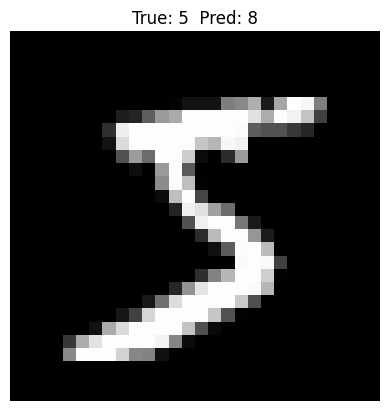

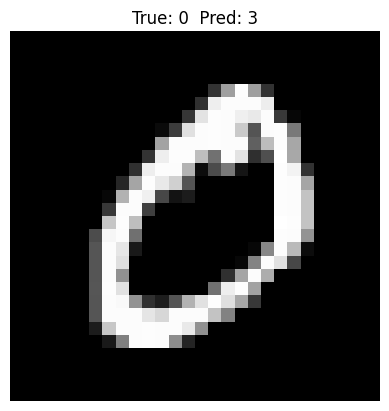

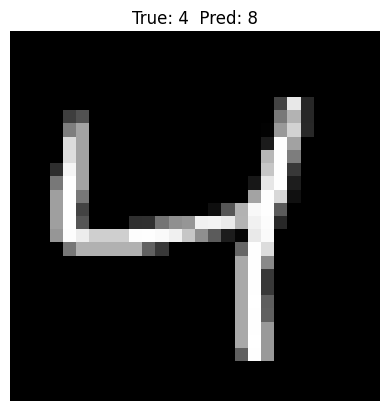

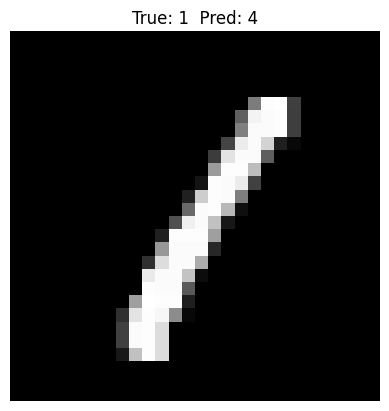

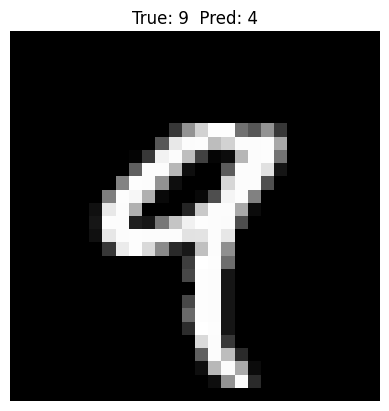

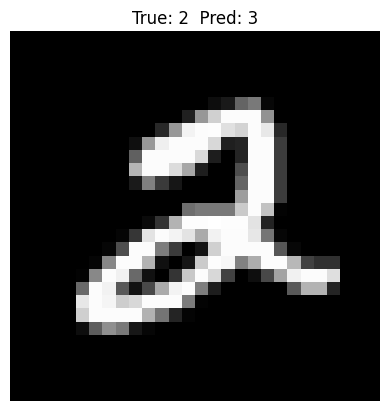

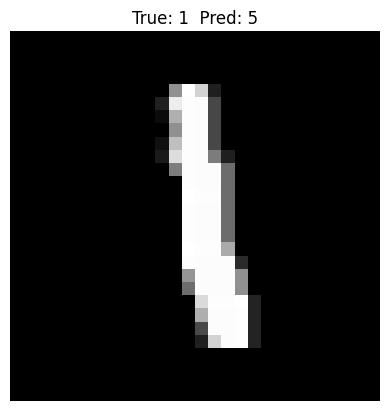

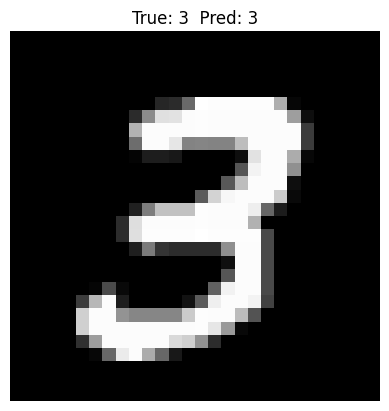

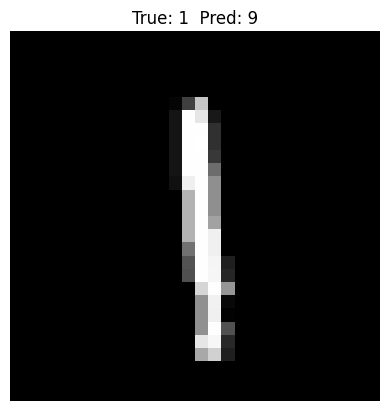

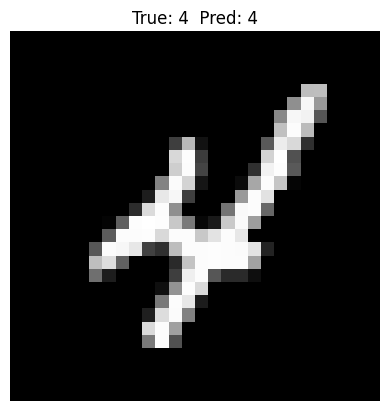

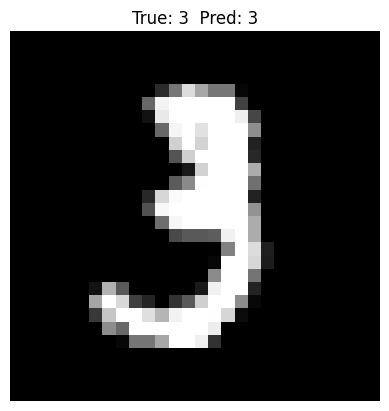

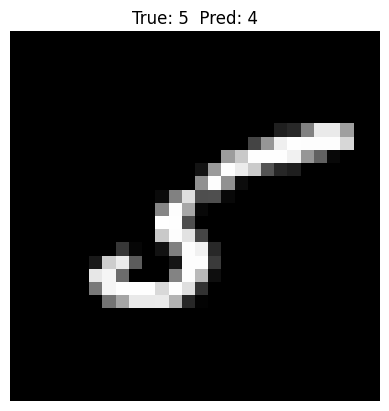

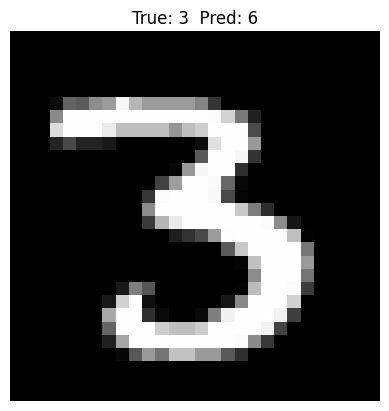

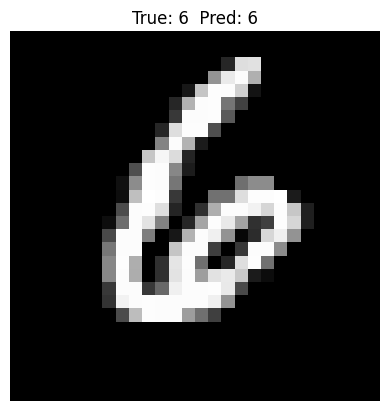

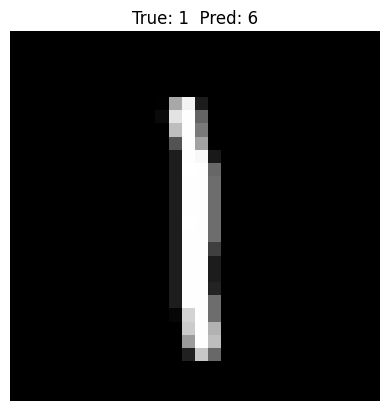

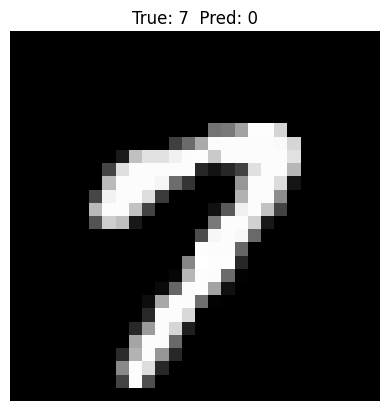

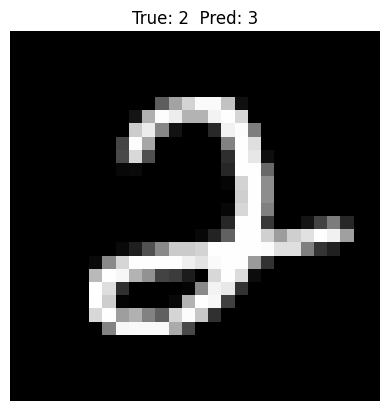

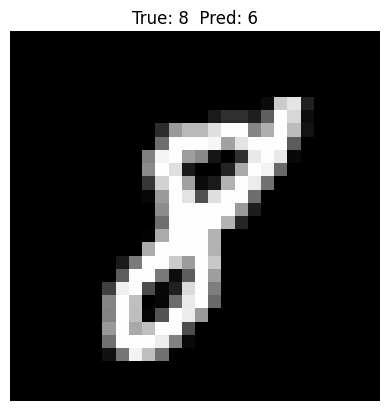

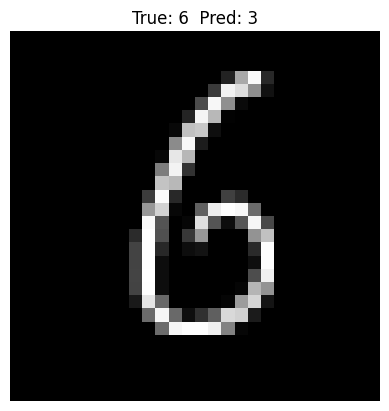

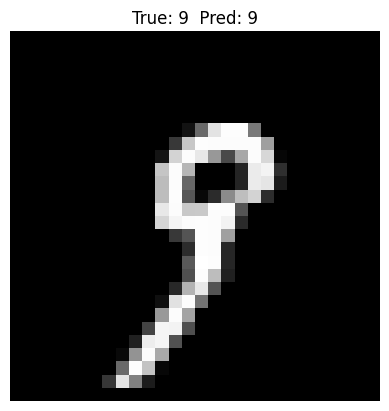

In [21]:
# test it on 10 examples
test_number = 20
# helper function to visualize an example
import matplotlib.pyplot as plt
import numpy as np

def pick_label(out):
    largest = 0
    index = 0
    for i in range(len(out)):
        if(out[i].data > largest):
            largest = out[i].data
            index = i
    return index
        
for i in range(test_number):
    forward_label = mnist_mlp(x_flat[i])
    show_mnist_example(x[i], pred_label=pick_label(forward_label), true_label=y[i])
    

In [ ]:
# get correct percentage on all examples
correct = 0

for i in range(len(x_flat)):
    forward_label = mnist_mlp(x_flat[i])
    pred = pick_label(forward_label)
    true = y[i]

    if(i % 10 == 0):
        print("calculating...")
    
    if pred == true:
        correct += 1

accuracy = (correct / len(x_flat)) * 100
print(f"Accuracy: {accuracy:.2f}%")


calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...
calculating...


In [9]:
accuracy = (correct / len(x_flat)) * 100
print(f"Accuracy: {accuracy:.2f}%")

NameError: name 'correct' is not defined

okay this takes years and isn't even very good lol, but I guess for just running a random MLP for 5 minutes, not tuning any hyper parameters, making it extremely small, it's not horrible. Show's the power of MLPs! 36% accuracy when a random guesser would be 10% right

I guess we're simulating the tech from that era in terms of cpu and how slow everything is lmao

So what does a single convolutional cell do? For simplicity I'm going to ignore stride and padding here for now.

We have a filter, which in this case will be 2D. The filter will have a height and a width. It will also have a bias term.

The filter is then slide across the input tensor. So it will slide over (input_width - filter_width) * (input_height - filter_height) times. At each of these positions / slides it will compute the dot product between the filter and the patch of the input. To compute the dot product we multiply each filter position with the corresponding input position. Then we sum all of those multiplications up. After calculating the dot product we add the bias. Then we apply our non-linearity (relu) to it and put it in the output.



In [10]:
# now let's implement the convolutional layer and max /average pooling layer and see how those do
# if this becomes too slow, and I realize now that I may need to do a torch implementation because this autograd engine
# is very slow lol. I guess because I'm using python lists and non-vectorized code everywhere

class Convolutional_Unit(Module):
    def __init__(self, kernel_height, kernel_width, **kwargs):
        self.kernel_width = kernel_width
        self.kernel_height = kernel_height
        self.kernel = []
        for i in range(kernel_height):
            self.kernel.append([Value(random.uniform(-1,1)) for _ in range(kernel_width)])
        self.b = Value(0)
    
    def __call__(self, x):
        out_height = len(x) - self.kernel_height + 1
        out_width = len(x[0]) - self.kernel_width + 1
        # slide it over the input, return a 2d list of values
        out = []
        for i in range(out_height):
            row = []
            for j in range(out_width):
                # quadrouple nested for loop lol
                # there's definitely a lot ofrepeated work here, maybe I should make a map of values later and store them lol
                # or just vectorize the code lol
                acc = Value(0)
                for kernel_i in range(self.kernel_height):
                    for kernel_j in range(self.kernel_width):
                        # print(self.kernel[kernel_i][kernel_j])
                        # print(x[i + kernel_i][j + kernel_j])
                        acc += self.kernel[kernel_i][kernel_j] * x[i + kernel_i][j + kernel_j]
                acc += self.b
                row.append(acc)
            out.append(row)
        return out

    def parameters(self):
        params = []
        for row in self.kernel:
            for param in row:
                params.append(param)
        return params + [self.b]

class Convolutional_Feature_Map(Module):
    def __init__(self, num_units, kernel_height, kernel_width, **kwargs):
        self.convolutional_units = [Convolutional_Unit(kernel_height, kernel_width) for _ in range(num_units)]
        self.num_units = num_units

    def __call__(self, x):
        out = []

        is_list_of_inputs = isinstance(x, list) and isinstance(x[0][0], list)

        for i in range(self.num_units):
            inp = x[i] if is_list_of_inputs else x
            out.append(self.convolutional_units[i](inp))

        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for c in self.convolutional_units for p in c.parameters()]
    
class Average_Pooling_Unit(Module):
    def __init__(self, window_height, window_width, stride_height, stride_width):
        self.window_width = window_width
        self.window_height = window_height
        self.stride_height = stride_height
        self.stride_width = stride_width

    def __call__(self, x):
        # for simplicity we have to ensure that the input size % stride == 0
        if(len(x) % self.stride_height != 0 or len(x[0]) % self.stride_width != 0):
            print("need to make it divisible bruh")
            return
        out_height = len(x) // self.stride_height
        out_width = len(x[0]) // self.stride_width

        out = [[0 for _ in range(out_width)] for _ in range(out_height) ]
        
        
        for i in range(out_height):
            for j in range(out_width):
                start_i = i * self.stride_height
                start_j = j * self.stride_width
                acc = Value(0)
                for k in range(self.window_height):
                    for l in range(self.window_width):
                        acc += x[start_i + k][start_j + l]
                out[i][j] = acc / (self.window_width * self.window_height)
        return out
                
    def parameters(self):
        return []

class Average_Pooling_Feature_Map(Module):
    def __init__(self, num_units, window_height, window_width, stride_height, stride_width, **kwargs):
        self.pooling_units = [Average_Pooling_Unit(window_height, window_width, stride_height, stride_width) for _ in range(num_units)]
        self.num_units = num_units

    def __call__(self, x):
        out = []
        for i in range(self.num_units):
            out.append(self.pooling_units[i](x[i]))
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return []

class Flatten(Module):
    def __call__(self, x):
        # hard coding this to take in a 3d array and put it to 1d
        out = []
        for i in range(len(x)):
            for j in range(len(x[0])):
                for k in range(len(x[0][0])):
                    out.append(x[i][j][k])
        return out
            
        
    def parameters(self):
        return []
        

class LeNet(Module):
    def __init__(self):
      self.layers =[
          # start by average pooling it down to reduce params?
          Convolutional_Feature_Map(6, 3, 3), # output shape should be (6, 26, 26)
          Average_Pooling_Feature_Map(6, 2, 2, 2, 2), # output shape should be (6 x (13 x 13))
          Convolutional_Feature_Map(6, 2, 2), # output shape should be (6 x (12 x 12))
          Flatten(),
          Fully_Connected_Layer(864, 32,nonlinearity="relu"),
          Fully_Connected_Layer(32, 10,nonlinearity="none"),
      ]
      
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        # print([p for layer in self.layers for p in layer.parameters()])
        return [p for layer in self.layers for p in layer.parameters()]


        
# we'll also need some sort of class that can wrap things and chain them together


In [15]:
print("starting")
lenet = LeNet()
lossi = []
learning_rate = 0.005
epochs = 32
batch_size = 4

print(len(lenet.parameters()))

for epoch in range(epochs):
    # Sample a random batch of data
    batch_indices = random.sample(range(len(x)), batch_size)
    batch_x = [x[i] for i in batch_indices]
    batch_y = [y[i] for i in batch_indices]

    average_loss_cum = Value(0)

    for xi, yi in zip(batch_x, batch_y):
        lenet.zero_grad()
        out = lenet(xi)
        loss = loss_individual(out, yi)
        loss.backward()
        average_loss_cum += loss
        for param in lenet.parameters():
            param.data -= learning_rate * param.grad

    print(average_loss_cum / batch_size)
    lossi.append(average_loss_cum / batch_size)

print("done")

starting
28100
38.6557932252291
38.025706742301296
5.99918223170088
47.526574548942804
30.10328667274754
33.65404633273378
32.88711592640697
22.379785311405985
25.480449568810826
32.40479435602681
18.446577435302615
24.211845936920216
14.994429800305078
17.736466812532043
8.360006086491165
21.894509406118544


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103409760>>
Traceback (most recent call last):
  File "/Users/julianhunt/Desktop/ML_Learning/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


6.617138044538731
15.601326638235221
26.958556764686403
2.6134989839464438
16.71819610532231
13.223654793692274
11.37354514841195
11.187643585026533
8.225561467157204
4.972054914362188
14.979591676275625
19.944834420232503
9.71424191096642
4.335094171762909
20.659363892385564
10.54486824397455
done


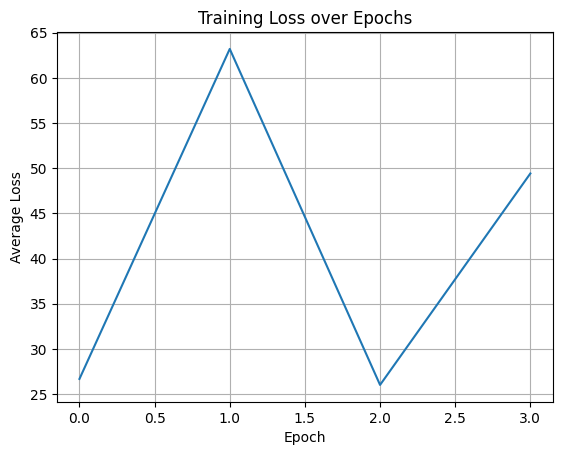

In [14]:
# test out how our new convolutional neural net learns
import matplotlib.pyplot as plt

# lossi = [v.data for v in lossi]

plt.plot(lossi)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

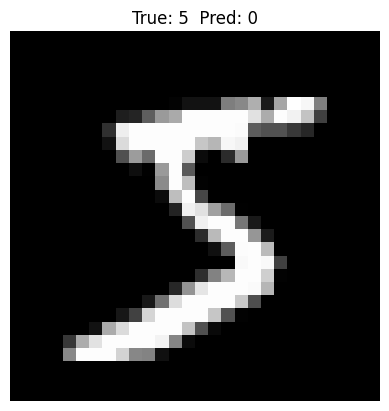

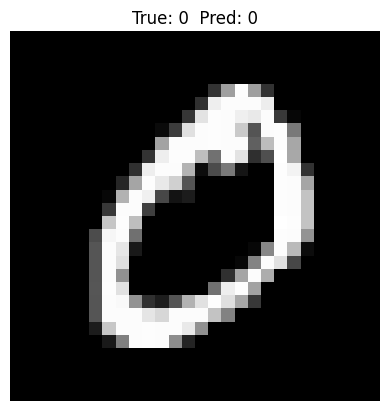

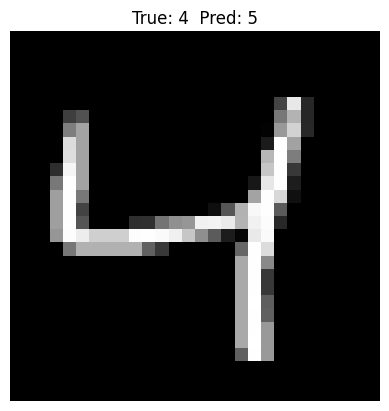

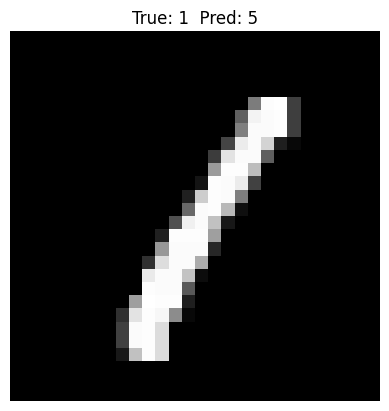

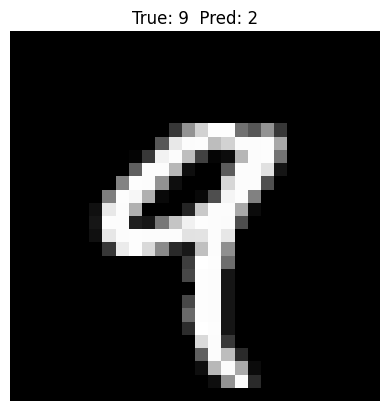

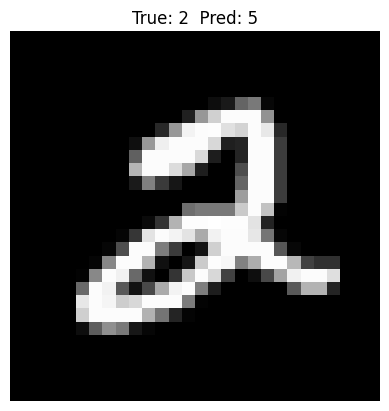

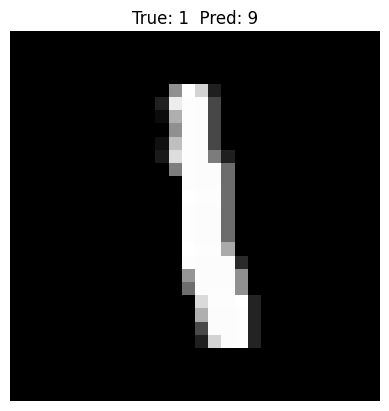

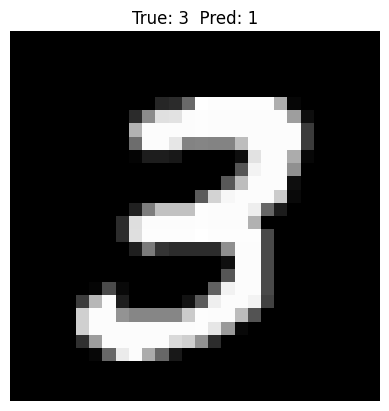

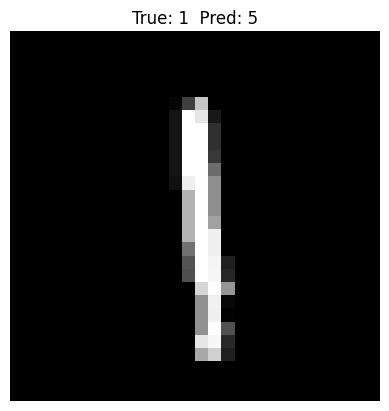

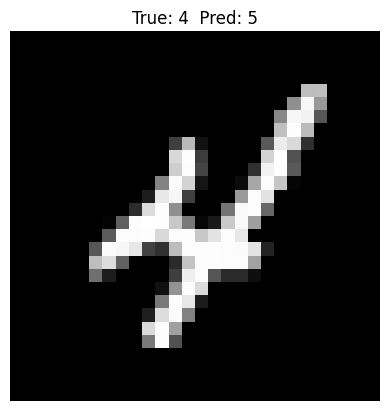

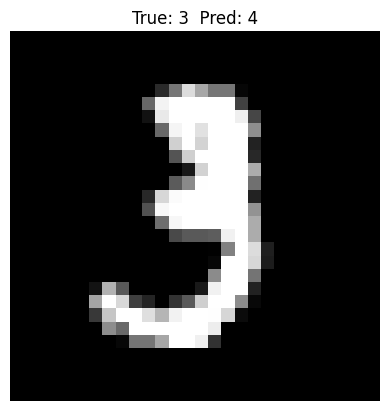

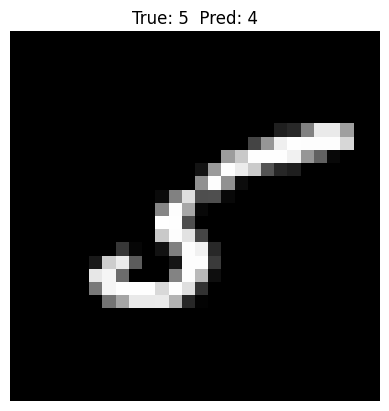

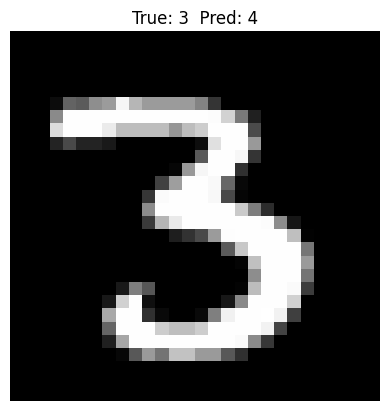

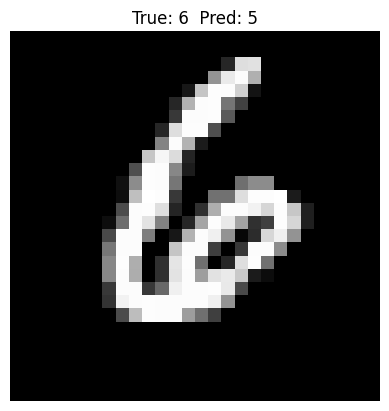

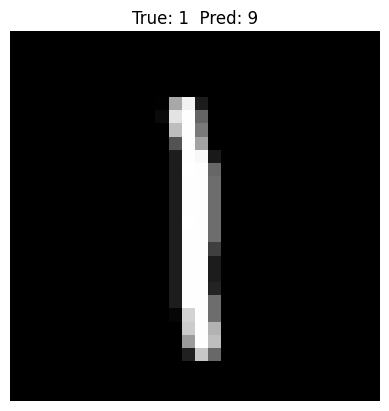

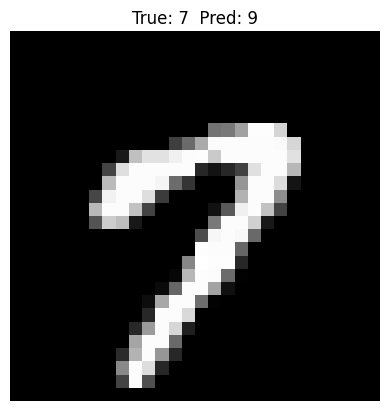

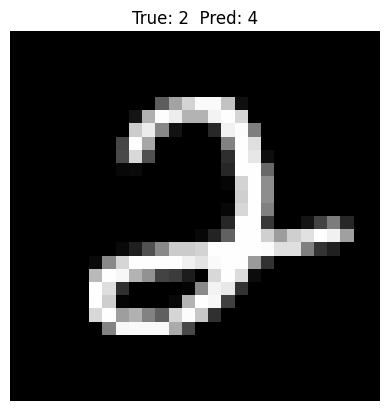

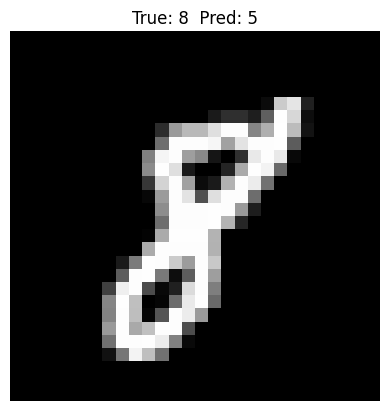

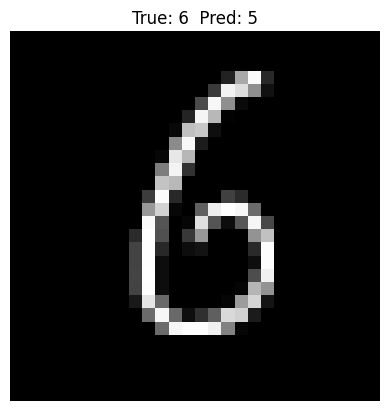

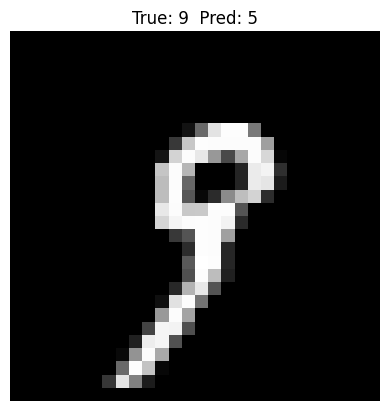

In [81]:
# test it on 10 examples
test_number = 20

for i in range(test_number):
    forward_label = lenet(x[i])
    show_mnist_example(x[i], pred_label=pick_label(forward_label), true_label=y[i])
    

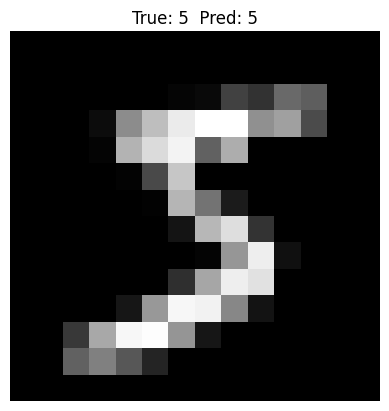

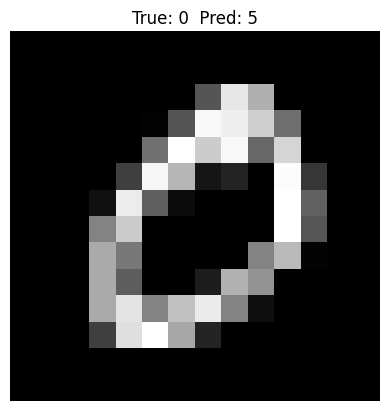

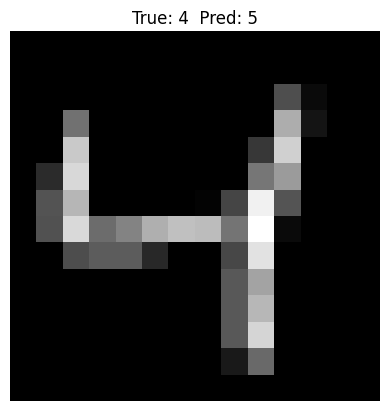

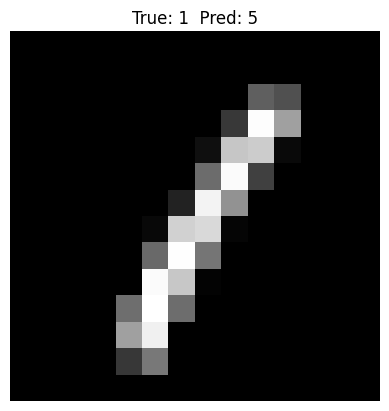

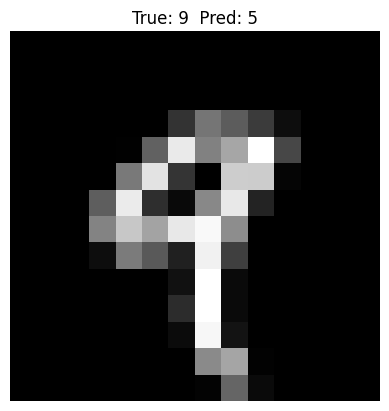

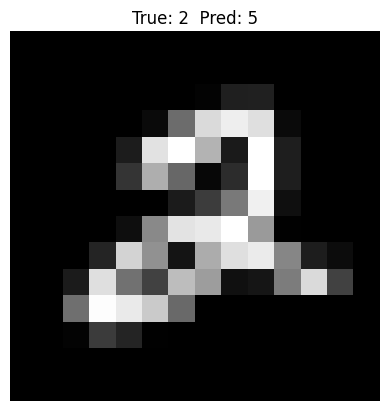

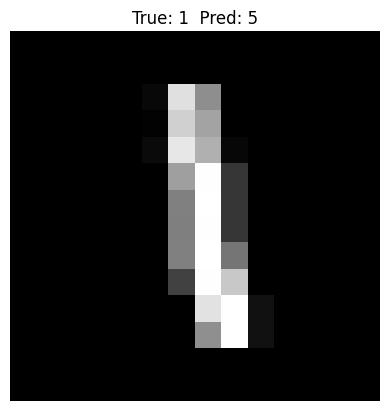

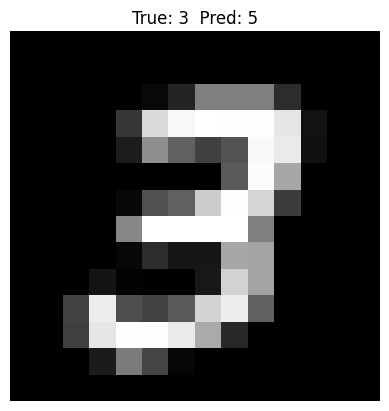

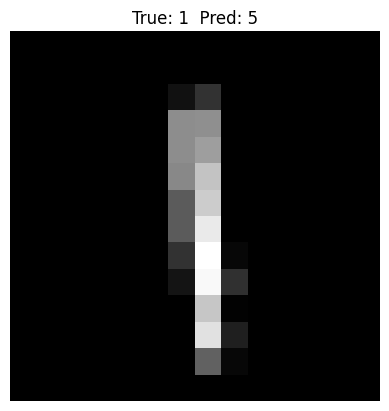

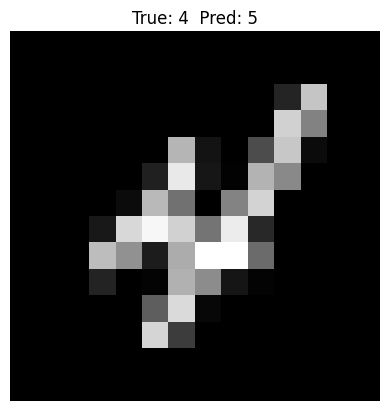

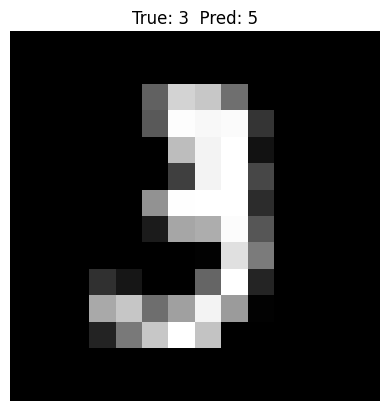

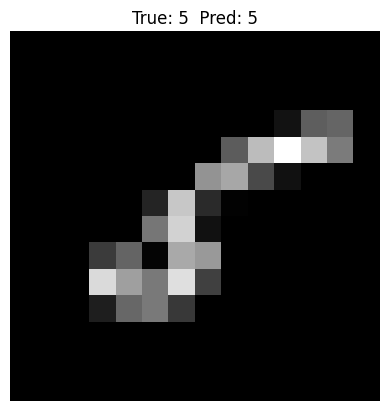

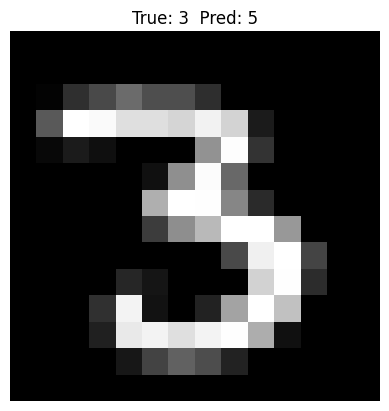

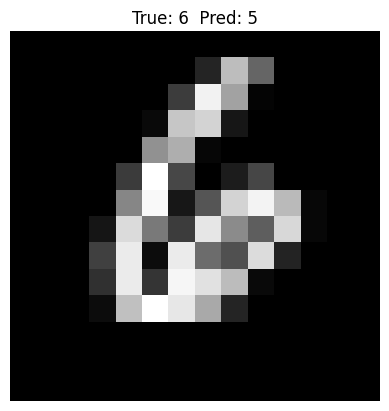

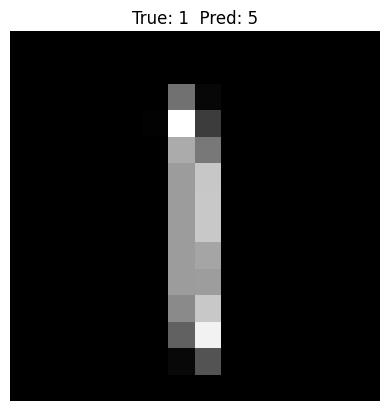

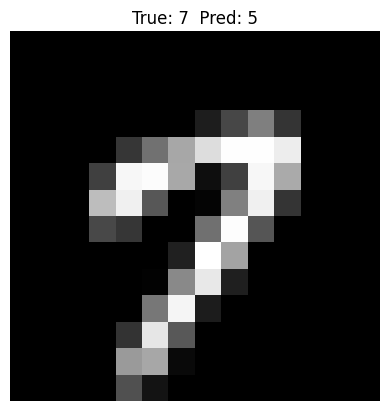

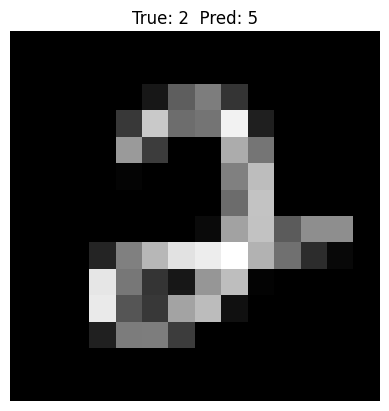

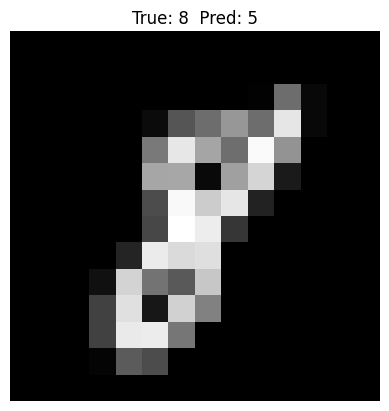

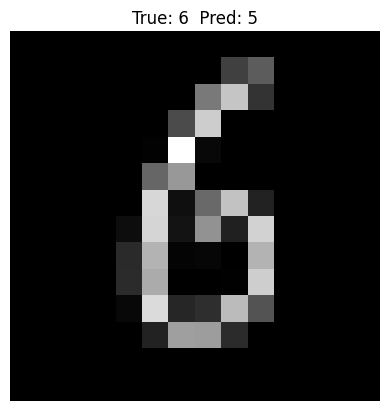

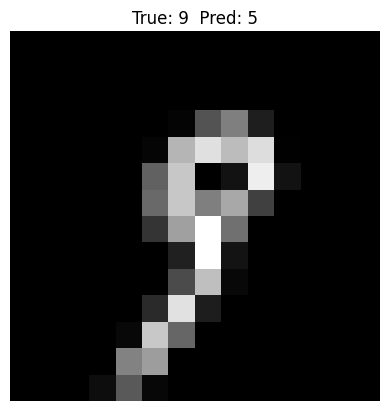

In [83]:
# visualize how it looks after average pooling
map = Average_Pooling_Feature_Map(1, 2, 2, 2, 2)
test_number = 20

for i in range(test_number):
    averages = map(x[i])
    vals = [[v.data for v in row] for row in averages]
    show_mnist_example(vals, pred_label=pick_label(forward_label), true_label=y[i])
    

I realized that there's some stuff in my implementation that isn't 100% right. These are what's wrong. I'm also reaching the limits of what I think this autograd implementation can do so I'm going to write out what the mistakes were and then create a new notebook that uses Pytorch to run things.

Here's what's wrong that I'm going to fix:
1. The CNNs are not fully connected to each other, I messed it up by assuming that there was no depth channel. When reading through how it was implemented I saw that they added a depth channel if it's RGB. Because my images were grey scale I though, I can just make it so that we don't have a depth channel. However this messed it up as I realized in each of my layers each convolutional unit is supposed to sum and have a kernel for each layer in the feature map that is being passed into it.
2. The handrolled autograd works but is seriously slow lol. Now I apprecaite vectorized code and pytorch. I think even if I just vectorized it and use numpy it would be faster.

So anyway I'm going to rewrite this in pytorch in a fresh notebook. Then I'll go over the different appendicies (a,b,c) from the paper and see if I can test those out. I'll try to make it a bit cleaner as well so that we split things into test, train val set, and we have some better metrics. I want to get those charts where we can see if it's underfitting / overfitting and other things too.